In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import backtest
import utils

## Spread settings comparison

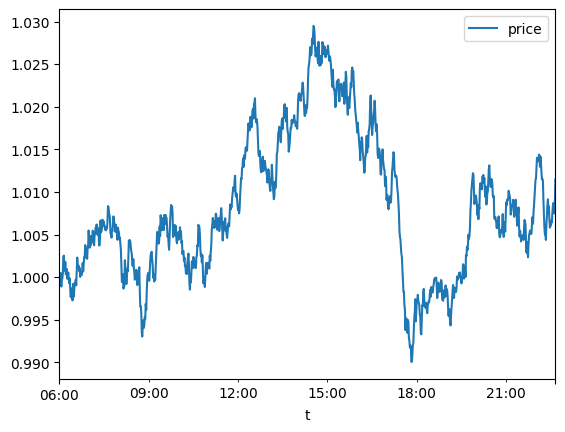

,t,signal
0,2025-01-01 06:00:00,0
1,2025-01-01 06:01:00,-1
2,2025-01-01 06:02:00,-1
3,2025-01-01 06:03:00,0
4,2025-01-01 06:04:00,-1


In [2]:
n = 1000
base_price = 1
rng = np.random.default_rng(seed=33)

price_df = utils.generate_random_prices(rng, n, base_price)
signal_df = utils.generate_random_signal(rng, n, side_probs=0.1)

price_df.plot(x='t', y='price')
plt.show()

signal_df.head()

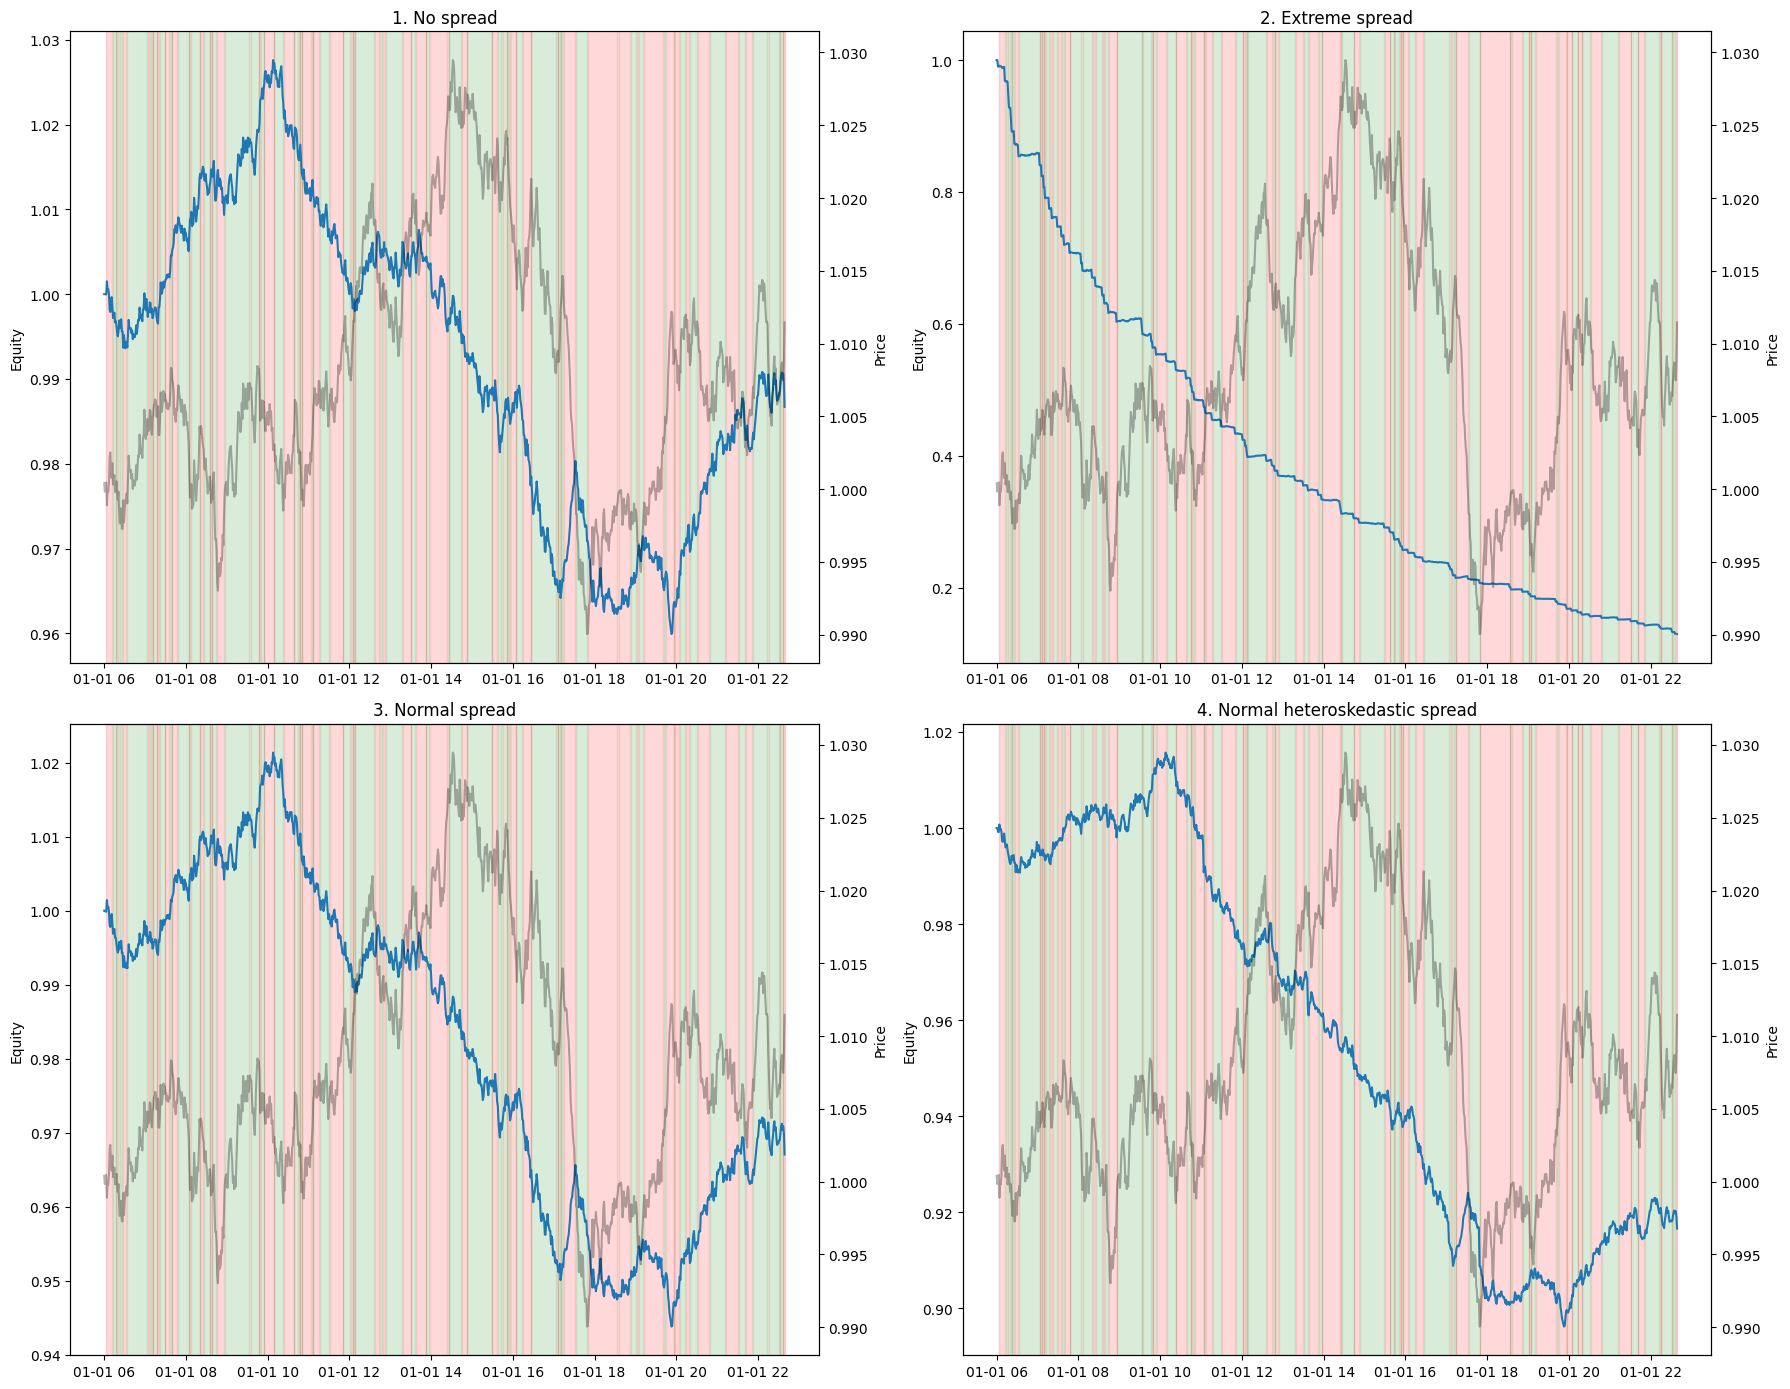

In [3]:
spread_df = utils.generate_random_spreads(rng, n, base_spread=0.0002, scale=2)
spread_settings = {
    '1. No spread': 0.0,
    '2. Extreme spread': 0.02,
    '3. Normal spread': 0.0002,
    '4. Normal heteroskedastic spread': spread_df
}

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
for setting, ax in zip(spread_settings, axes.flatten()):
    ax2 = ax.twinx()
    return_df = backtest.backtester(price_df, signal_df, spread=spread_settings[setting])
    utils.draw_results(ax, ax2, return_df, price_df, fig_title=setting)

plt.tight_layout()
plt.show()

Considering the strategy uses a fixed position size, the equity curve closely tracks the price path during long positions (green shading), and mirrors it with opposite sign during short positions (red). 

1. In the absence of spread, final equity is the highest, as no transaction costs are paid.
2. At the opposite extreme, with a large spread (2% of midprice), note how equity drops every time position changes side, as spread costs dominate PnL.
3. With realistic constant spread (0.02% of midprice), final equity is slightly lower than in no-spread case, but individual per-trade spread costs are not visually prominent in the curve.
4. Finally, with heteroskedastic spread modeled as the same 0.02% multiplied by log-normal noise, the curve mostly resembles the constant-spread case. However, there are noticeable points where equity drops more sharply on position changes, corresponding to trades executed during periods of high spread (e.g. the drop just before 18:00 is sharper than its counterpart in the constant-spread example).

## Absolute spread example

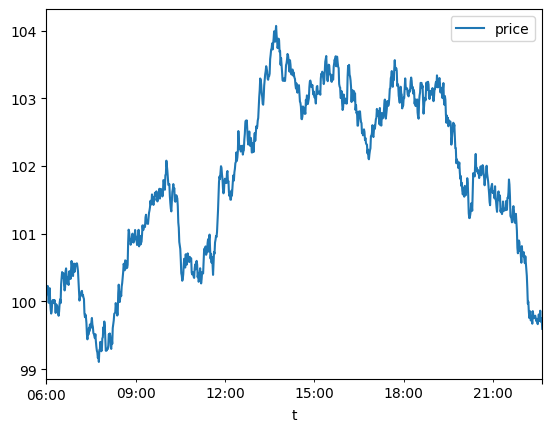

,t,signal
0,2025-01-01 06:00:00,0
1,2025-01-01 06:01:00,0
2,2025-01-01 06:02:00,0
3,2025-01-01 06:03:00,0
4,2025-01-01 06:04:00,0


In [4]:
n = 1000
base_price = 100
rng = np.random.default_rng(seed=32)

price_df = utils.generate_random_prices(rng, n, base_price)
signal_df = utils.generate_random_signal(rng, n, side_probs=0.1)

price_df.plot(x='t', y='price')
plt.show()

signal_df.head()

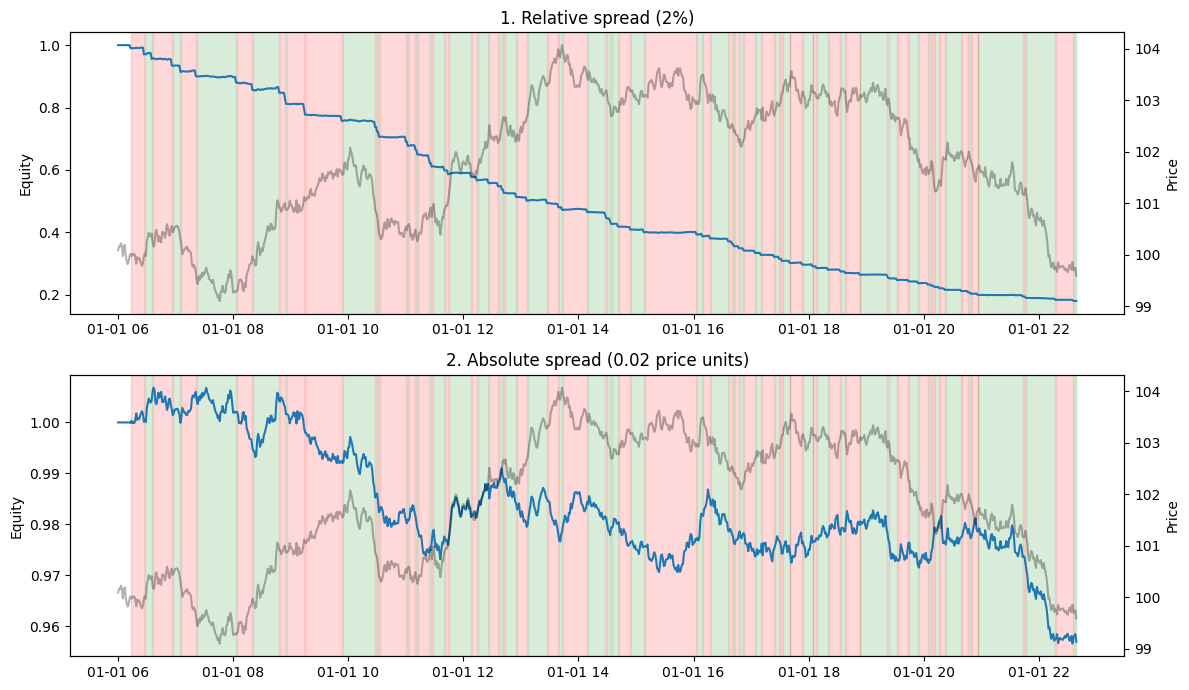

In [5]:
rel_spread_settings = {
    '1. Relative spread (2%)': True,
    '2. Absolute spread (0.02 price units)': False
}

fig, axes = plt.subplots(2, 1, figsize=(12, 7))
for setting, ax in zip(rel_spread_settings, axes.flatten()):
    ax2 = ax.twinx()
    return_df = backtest.backtester(price_df, signal_df, spread=0.02, spread_is_relative=rel_spread_settings[setting])
    utils.draw_results(ax, ax2, return_df, price_df, fig_title=setting)

plt.tight_layout()
plt.show()

Here we use prices centered around 100 and spread value equal to 0.02 under two spread conventions:

1. Relative spread - in this case the spread corresponds to 2% of price, so each position change (except the first one) incurs a round-trip transaction cost of 2%. As a result, equity is dominated by spread costs and drops sharply on every trade.
2. Absolute spread - with prices centered around 100, the spread corresponds to 0.02% of price on average. In this case the equity curve behaves realistically, without sharp drops on each position change.

# Long-only execution example

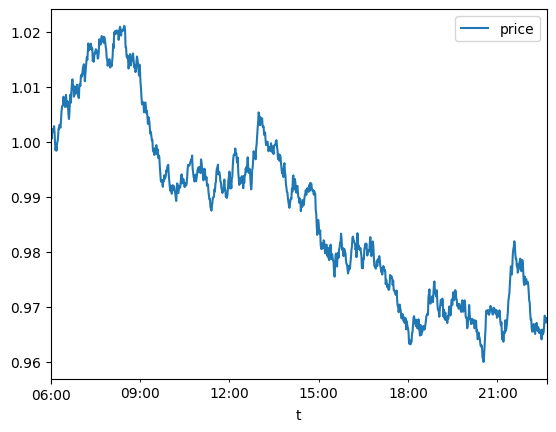

,t,signal
0,2025-01-01 06:00:00,0
1,2025-01-01 06:01:00,0
2,2025-01-01 06:02:00,0
3,2025-01-01 06:03:00,0
4,2025-01-01 06:04:00,0


In [6]:
n = 1000
base_price = 1
rng = np.random.default_rng(seed=333)

price_df = utils.generate_random_prices(rng, n, base_price)
signal_df = utils.generate_random_signal(rng, n, side_probs=0.067)

price_df.plot(x='t', y='price')
plt.show()

signal_df.head()

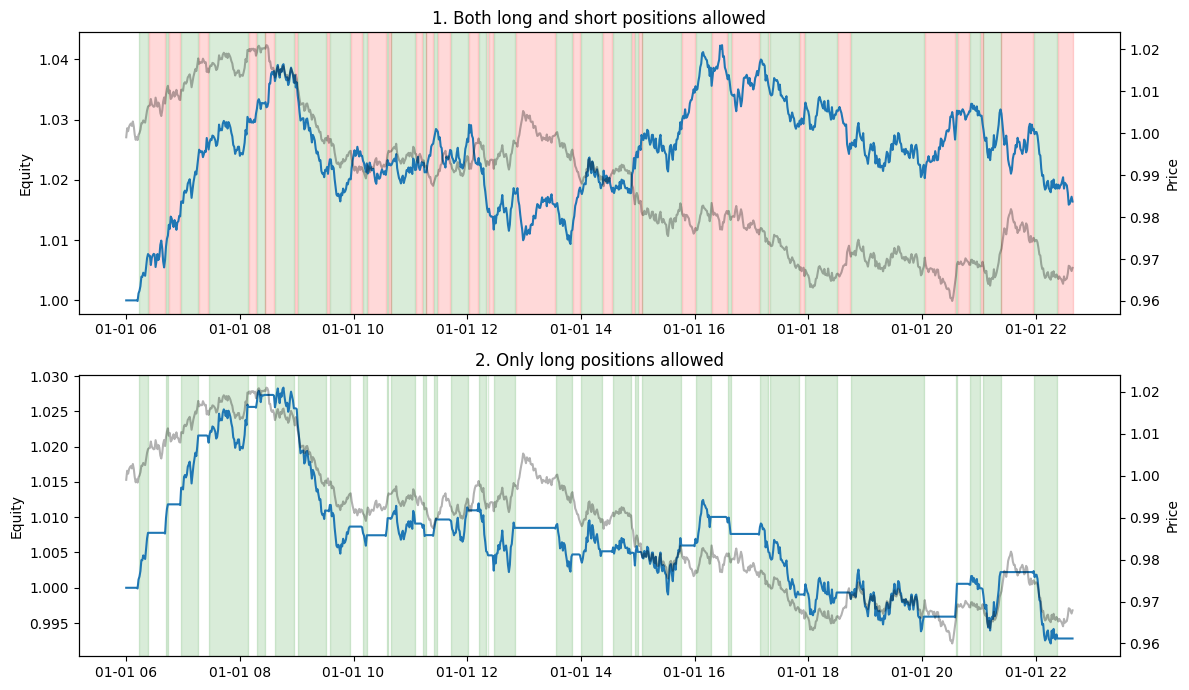

In [7]:
allow_shorts_settings = {
    '1. Both long and short positions allowed': True,
    '2. Only long positions allowed': False
}
spread = 0.0002

fig, axes = plt.subplots(2, 1, figsize=(12, 7))
for setting, ax in zip(allow_shorts_settings, axes.flatten()):
    ax2 = ax.twinx()
    return_df = backtest.backtester(price_df, signal_df, spread=spread, allow_shorts=allow_shorts_settings[setting])
    utils.draw_results(ax, ax2, return_df, price_df, fig_title=setting)

plt.tight_layout()
plt.show()

Many real-world strategies are long-only. This experiment compares equity curves generated from the same signal executed with or without allowing short positions (allow_shorts=True/False). When shorts are allowed, the strategy alternates between long and short exposure. In the long-only case, periods corresponding to positive signals exhibit identical equity dynamics, while negative signal periods result in a flat equity curve due to the position being closed rather than reversed.